In [12]:
import tensorflow
import keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense ,Conv2D ,Conv2DTranspose ,Dropout ,BatchNormalization ,Input ,MaxPooling2D ,concatenate
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from google.colab import drive
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
import os
from tensorflow.keras.optimizers import Adam
from google.colab.patches import cv2_imshow

In [13]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [14]:
train_input_dir = '/content/gdrive/My Drive/train_input_870'
train_output_dir = '/content/gdrive/My Drive/train_output_870'
test_input_dir = '/content/gdrive/My Drive/test_input_20'
test_output_dir = '/content/gdrive/My Drive/test_output_20'

In [15]:
def images(dir_train,dir_test):
  images = os.listdir(dir_train)
  images_ = os.listdir(dir_test)
  k = random.choice(images)
  k_ = random.choice(images_)
  file_train = dir_train + '/' + k
  file_test = dir_test + '/' + k_
  print(len(images))
  print(len(images_))
  img = cv2.resize(cv2.imread(file_train),(256,256))
  img_ = cv2.resize(cv2.imread(file_test),(256,256))
  cv2_imshow(img)
  cv2_imshow(img_)

870
870


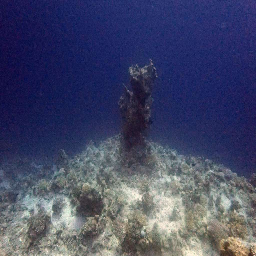

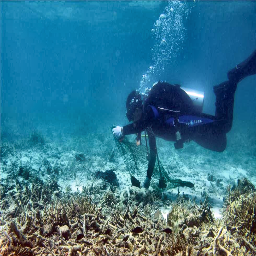

In [16]:
images(train_input_dir,train_output_dir)

In [17]:
def conv_model(hidden_size):
    input_layer = Input((256,256,3))
    conv_1 = Conv2D(hidden_size * 1,(3,3),activation = "relu" ,padding = "same")(input_layer)
    conv_1 = Conv2D(hidden_size * 1,(1,1),activation = "relu" ,strides=(2,2))(conv_1)


    conv_2 = Conv2D(hidden_size * 2,(3,3),activation = "relu" ,padding = "same")(conv_1)
    conv_2 = Conv2D(hidden_size * 2,(1,1),activation = "relu" ,strides=(2,2))(conv_2)

    conv_3 = Conv2D(hidden_size * 4,(3,3),activation = "relu" ,padding = "same")(conv_2)
    conv_3 = Conv2D(hidden_size * 4,(1,1),activation = "relu" ,strides=(2,2))(conv_3)

    conv_4 = Conv2D(hidden_size * 8,(3,3),activation = "relu" ,padding = "same")(conv_3)
    conv_4 = Conv2D(hidden_size * 8,(1,1),activation = "relu" ,strides=(2,2))(conv_4)

    
    conv_m = Conv2D(hidden_size * 32,(3,3),activation = "relu" ,padding = "same")(conv_4)
    conv_m = Conv2D(hidden_size * 32,(1,1),activation = "relu" ,strides=(2,2))(conv_m)

    de_conv_4 = Conv2DTranspose(hidden_size * 8, (3, 3), strides=(2, 2), padding="same")(conv_m)
    de_conv_4 = concatenate([de_conv_4 , conv_4])
    de_conv_4 = Conv2D(hidden_size * 8, (3, 3), activation="relu", padding="same")(de_conv_4)
    de_conv_4 = Conv2D(hidden_size * 8, (3, 3), activation="relu", padding="same")(de_conv_4)

    de_conv_3 = Conv2DTranspose(hidden_size * 4, (3, 3), strides=(2, 2), padding="same")(de_conv_4)
    de_conv_3 = concatenate([de_conv_3 , conv_3])
    de_conv_3 = Conv2D(hidden_size * 4, (3, 3), activation="relu", padding="same")(de_conv_3)
    de_conv_3 = Conv2D(hidden_size * 4 ,(3, 3), activation="relu", padding="same")(de_conv_3)

    de_conv_2 = Conv2DTranspose(hidden_size * 2, (3, 3), strides=(2, 2), padding="same")(de_conv_3)
    de_conv_2 = concatenate([de_conv_2 , conv_2])
    de_conv_2 = Conv2D(hidden_size * 2, (3, 3), activation="relu", padding="same")(de_conv_2)
    de_conv_2 = Conv2D(hidden_size * 2, (3, 3), activation="relu", padding="same")(de_conv_2)

    de_conv_1 = Conv2DTranspose(hidden_size * 2, (3, 3), strides=(2, 2), padding="same")(de_conv_2)
    #de_conv_1 = concatenate([de_conv_1 , conv_1])
    de_conv_1 = Conv2D(hidden_size * 2, (3, 3), activation="relu", padding="same")(de_conv_1)
    de_conv_1 = Conv2D(hidden_size * 2 ,(3, 3), activation="relu", padding="same")(de_conv_1)

    output_layer = Conv2D(3, (1,1), padding="same", activation="sigmoid")(de_conv_1)

    model = Model(inputs = [input_layer] ,outputs = [output_layer])
    return model


model = conv_model(32)                                                                      



In [18]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 256, 256, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 32) 1056        conv2d_19[0][0]                  
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 128, 128, 64) 18496       conv2d_20[0][0]                  
_______________________________________________________________________________________

In [19]:
import tensorflow as tf
def loss_fn(y_true,y_pred):
    mae = tf.keras.losses.MeanAbsoluteError()
    k = mae(y_true, y_pred)
    k = (k/(256*256))
    ssim = tf.image.ssim(y_true *255 , y_pred * 255, max_val = 255, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03)
    m = (1-ssim)/2
    return ((0.3*k) + (0.7*m))
model.compile(optimizer = Adam(lr = 0.0001),loss = loss_fn ,metrics = [tf.keras.metrics.MeanSquaredError()])

In [20]:
def load_file(fname ,path_input,path_output):
  image  = path_input + '/' + fname
  image_ = path_output + '/' + fname
  img = cv2.imread(image)
  img_ = cv2.imread(image_)
  img = cv2.resize(img,(256,256))
  img_ = cv2.resize(img_,(128,128))
  return(img,img_)

In [21]:
def data_generator(path_train,path_test,batch_size_):

  fnames_train = os.listdir(path_train)
  fnames_test = os.listdir(path_test)

  random.shuffle(fnames_train)
  random.shuffle(fnames_test)

  print(len(fnames_train))
  print(len(fnames_test))

  no_of_batches = len(fnames_train)//batch_size_

  for i in range(no_of_batches+1):
    X_train = []
    Y_train = []
    print('training batch no {}'.format(i+1))
    try:
      present_train = fnames_train[i*batch_size_:(i+1)*batch_size_]
      present_test  = fnames_test[i*batch_size_:(i+1)*batch_size_]
    except:
      present_train = fnames_train[i*batch_size_:]
      present_test  = fnames_test[i*batch_size_:]
      
    for name_train in present_train: 
      tup_train = load_file(name_train,path_train,path_test)
      X_train.append(tup_train[0])
      Y_train.append(tup_train[1])

    X_train = (np.asarray(X_train)/255.0)
    Y_train = (np.asarray(Y_train)/255.0)

    history = model.fit(X_train,Y_train,batch_size = 16 ,epochs = 40 ,verbose = 1,shuffle = True)

  return history

In [22]:
history = data_generator(train_input_dir,train_output_dir ,batch_size_ = 300)

870
870
training batch no 1
Epoch 1/40
19/19 [==============================] - 5s 259ms/step - loss: 0.2708 - mean_squared_error: 0.0686
Epoch 2/40
19/19 [==============================] - 5s 257ms/step - loss: 0.2638 - mean_squared_error: 0.0702
Epoch 3/40
19/19 [==============================] - 5s 257ms/step - loss: 0.2319 - mean_squared_error: 0.0830
Epoch 4/40
19/19 [==============================] - 5s 258ms/step - loss: 0.1877 - mean_squared_error: 0.0569
Epoch 5/40
19/19 [==============================] - 5s 256ms/step - loss: 0.1684 - mean_squared_error: 0.0449
Epoch 6/40
19/19 [==============================] - 5s 258ms/step - loss: 0.1578 - mean_squared_error: 0.0376
Epoch 7/40
19/19 [==============================] - 5s 257ms/step - loss: 0.1502 - mean_squared_error: 0.0339
Epoch 8/40
19/19 [==============================] - 5s 256ms/step - loss: 0.1457 - mean_squared_error: 0.0333
Epoch 9/40
19/19 [==============================] - 5s 257ms/step - loss: 0.1404 - mean_squa

In [28]:
def get_result(image ,plot = True):

    image = image.reshape((-1,256,256 ,3))
    image_ = ((image/255.0))
    raw_result = model.predict(image_)
    result = raw_result.reshape((128,128,3))
    result = 255*((result))
    if plot:
        cv2_imshow(image.reshape((128,128,3)))
        cv2_imshow(result)
    return result

In [29]:
model.save('/content/gdrive/My Drive/weights.h5')

In [30]:
sett =('/content/gdrive/My Drive/rod2.jpg')

test_input


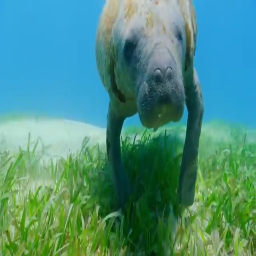

test_output


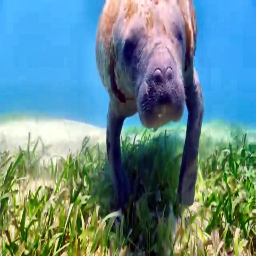

predicted_op


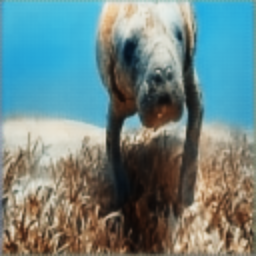

AUV input


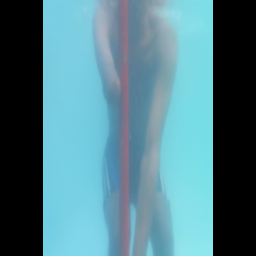

In [31]:
image = os.listdir(test_input_dir)
img =  random.choice(image)
img_dir = test_input_dir + '/' +img
img_dir_ = test_output_dir + '/' +img
img_dire = sett 
image = cv2.resize(cv2.imread(img_dir),(256,256))
image_ = cv2.resize(cv2.imread(img_dir_),(256,256))
image__ = cv2.resize(cv2.imread(img_dire),(256,256))
result = get_result(image ,plot = False)
result1 = get_result(image__ ,plot = False)
result = cv2.resize(result,(256,256))
result1 = cv2.resize(result1,(256,256))
print("test_input")
cv2_imshow(image)
print("test_output")
cv2_imshow(image_)
print("predicted_op")
cv2_imshow(result)
print("AUV input")
cv2_imshow(image__)


predicted AUV output


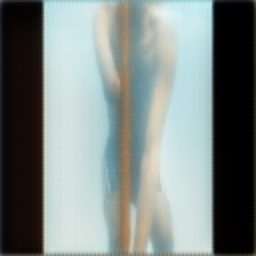

In [32]:
print("predicted AUV output")
cv2_imshow(result1)